# Evaluate Model

## Load the dataset

In [38]:
import scipy.io
import numpy as np
import cv2
from pathlib import Path
import glob
from tqdm import tqdm
import scipy.io

def load_umich_indoor_corridor_dataset(dataset_path, dataset_name, 
                                       image_size=(400, 695), gray=False,
                                       scaling=True, verbose=True):
    # Load images
    image_filenames = glob.glob(str(Path(dataset_path) / 'dataset' / dataset_name / '*.ppm'))
    image_filenames = sorted(image_filenames)
    image_filenames = image_filenames[::10] # 10 fps of labeling
    images = np.empty((len(image_filenames), *image_size, 1 if gray else 3), dtype=np.float)
    for i, image_filename in enumerate(tqdm(image_filenames, total=len(image_filenames), desc="Loading images", disable=not verbose)):
        if gray:
            image = cv2.imread(image_filename, cv2.IMREAD_GRAYSCALE)
            image = np.expand_dims(image, -1)
        else:
            image = cv2.imread(image_filename, cv2.IMREAD_COLOR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if image.shape[:2] != image_size:
            image = cv2.resize(image, tuple(reversed(image_size)))
            image = np.expand_dims(image, -1)
        if scaling: image = image / 255.0 # Normalization
        images[i, ...] = image

    # Load labels
    label_filenames = glob.glob(str(Path(dataset_path) / 'ground_truth' / dataset_name / '*.mat'))
    label_filenames = sorted(label_filenames)
    labels = np.empty((len(label_filenames), *image_size, 1), dtype=np.float)
    for i, label_filename in enumerate(tqdm(label_filenames, total=len(label_filenames), desc="Loading labels", disable=not verbose)):
        label = scipy.io.loadmat(label_filename)['ground_truth']
        label = np.array((label == -1), dtype='uint8')
        if label.shape[:2] != image_size:
            label = cv2.resize(label, tuple(reversed(image_size)))
        label = np.expand_dims(label, -1)
        labels[i, ...] = label

    assert len(images) == len(labels)
    return images, labels

In [39]:
DATASET_PATH = '/home/kerry/Documents/dataset/Michigan Indoor Corridor Dataset/UmichIndoorCorridor2012'

## Load the model

In [40]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import metrics
from tensorflow.keras.models import load_model
from tensorflow.keras import metrics

def mean_IoU(target, pred):
    m = metrics.MeanIoU(num_classes=2)
    return m(target, pred > 0.5)

model = load_model('models/model-gs-unet.h5', compile=False)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", mean_IoU])

## Evaluation

Evaluating on Dataset_+:
31/31 [==============================] - 0s 12ms/sample - loss: 0.4909 - accuracy: 0.7693 - mean_IoU: 0.6173


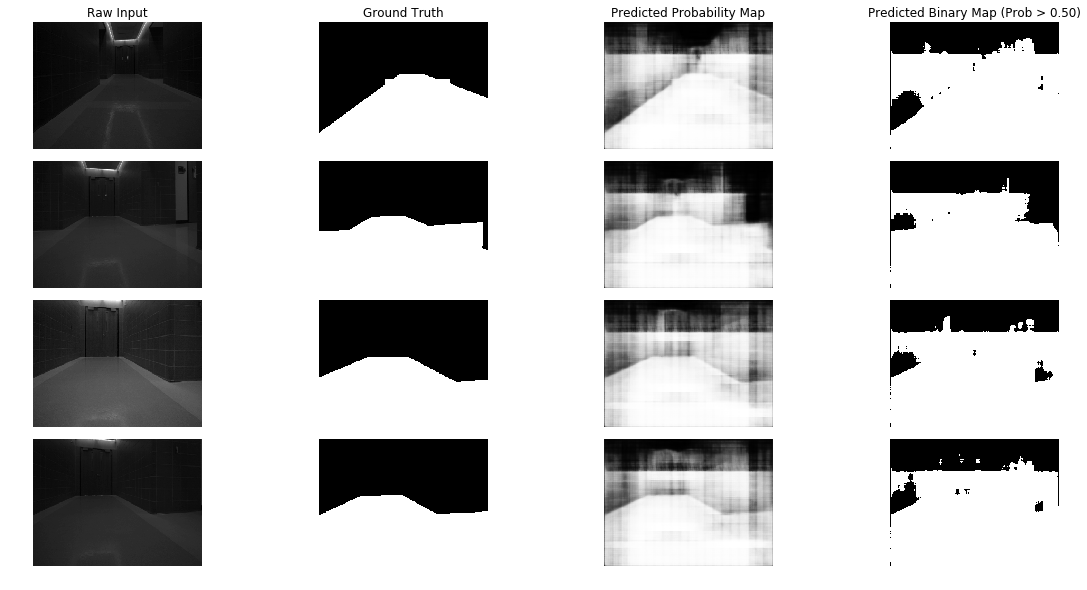

Evaluating on Dataset_L:
93/93 [==============================] - 1s 9ms/sample - loss: 0.3053 - accuracy: 0.8552 - mean_IoU: 0.6872


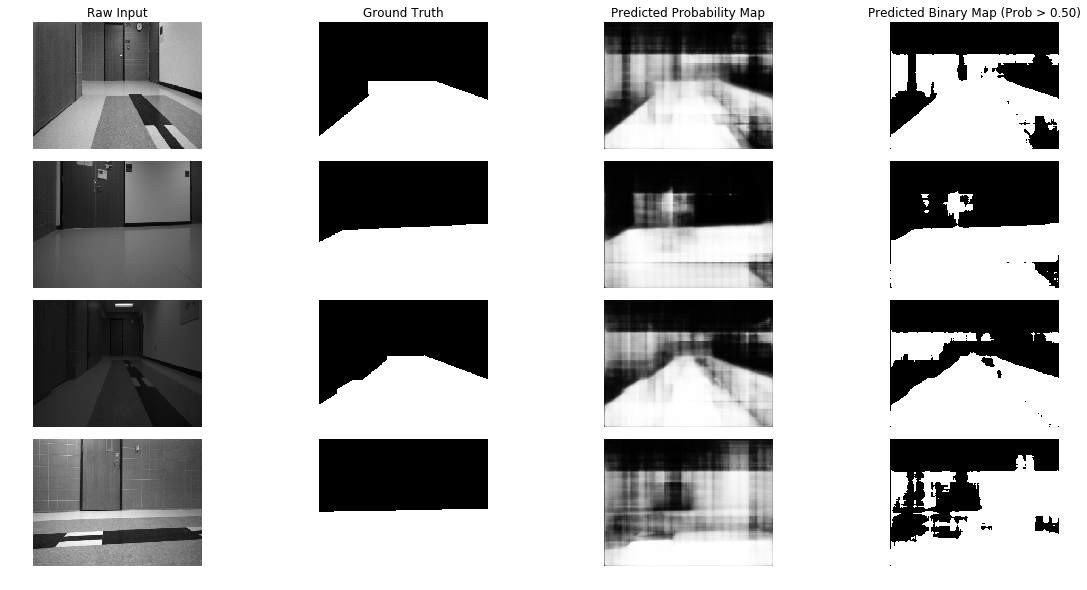

Evaluating on Dataset_T_1:
42/42 [==============================] - 0s 9ms/sample - loss: 0.4240 - accuracy: 0.7752 - mean_IoU: 0.6972


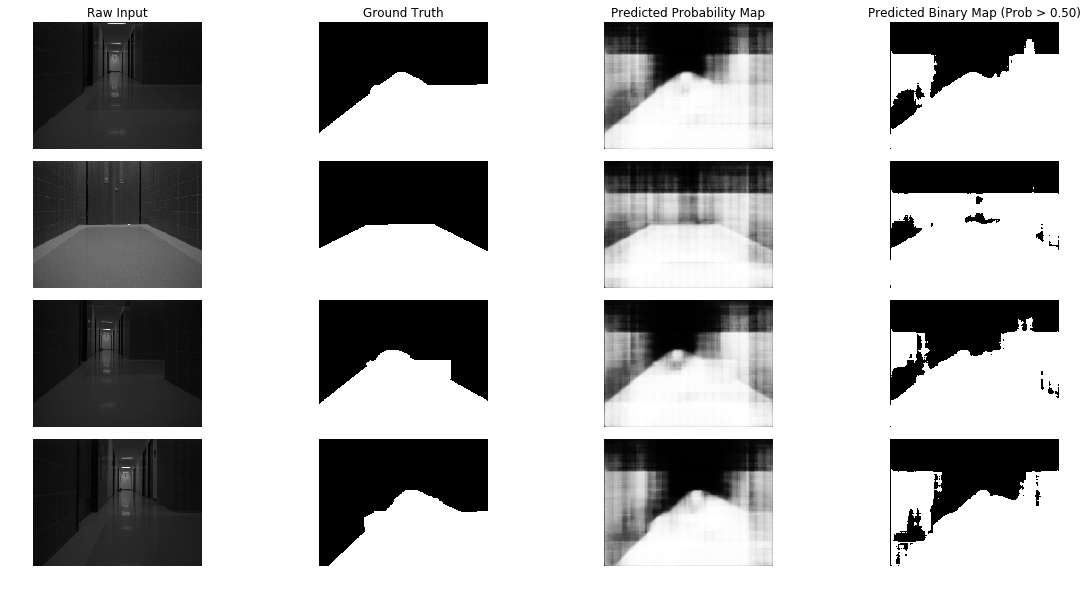

Evaluating on Dataset_T_2:
37/37 [==============================] - 0s 8ms/sample - loss: 0.3614 - accuracy: 0.8230 - mean_IoU: 0.6917


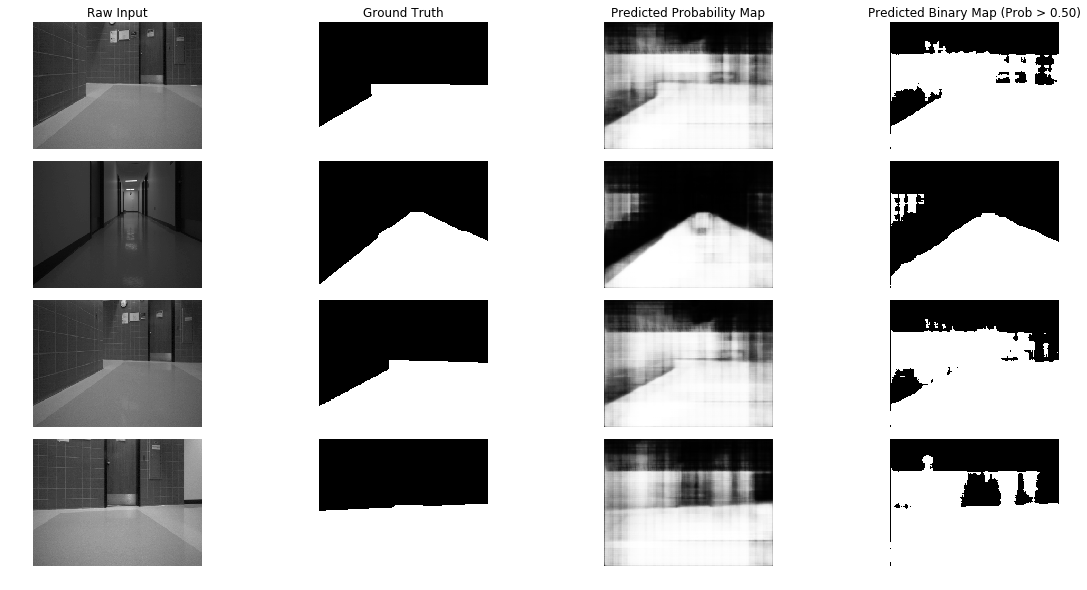

In [41]:
from utils.plot import plot_samples
from matplotlib import pyplot as plt

dataset_names = ['Dataset_+', 'Dataset_L', 'Dataset_T_1', 'Dataset_T_2']
for dataset_name in dataset_names:
    images, labels = load_umich_indoor_corridor_dataset(DATASET_PATH, dataset_name, image_size=(240, 320), gray=True, verbose=False)
    print('Evaluating on %s:' % (dataset_name))
    model.evaluate(images, labels, verbose=1)
    preds = model.predict(images)
    plot_samples(images, labels, preds, num_samples=4, prob=0.5, seed=1)
    plt.show()